In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix as cm,
    accuracy_score as acc,
    precision_score as prec,
    recall_score as rec,
    f1_score as f1
)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from ml_model_eval import pred_proba_plot, plot_cross_val_confusion_matrix, plot_learning_curve
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
matches = pd.read_csv("../matches_after_preprocessing.csv")

In [9]:
train = matches[matches["date"] < '2022-11-01']
test = matches[matches["date"] > '2022-11-01']
predictors = ["venue_code", "opp_code", "hour", "day_code", "gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"]
X_train = train[predictors]
y_train = train["target"]
X_test = test[predictors]
y_test = test["target"]
X_test.drop(["gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"], axis =1)

,venue_code,opp_code,hour,day_code
0,0,10,12,5
1,1,3,16,6
2,0,16,16,6
3,1,19,15,5
4,1,2,15,5
...,...,...,...,...
1717,0,17,14,6
1718,0,19,20,0
1719,1,9,15,5
1720,0,4,14,6


In [11]:
# Tạo và huấn luyện mô hình MLP
mlp = MLPClassifier(max_iter=500)
mlp.fit(X_train, y_train)

# Dự đoán kết quả
preds = mlp.predict(X_test)

# Tính toán các độ đo
confusion_matrix = cm(y_test, preds)
accuracy_score = acc(y_test, preds)
precision_score = prec(y_test, preds)
recall_score = rec(y_test, preds)
f1_score = f1(y_test, preds)

In [12]:
print("Confusion matrix:", confusion_matrix)
print("Accuracy score:", accuracy_score)
print("Precision score:", precision_score)
print("Recall score:", recall_score)
print("F1 score:", f1_score)

Confusion matrix: [[697 204]
 [336 242]]
Accuracy score: 0.6348884381338742
Precision score: 0.5426008968609866
Recall score: 0.4186851211072664
F1 score: 0.47265625


In [13]:
hidden_layer_test = []
for i in range(6,20,4):
 a = list(range(6,18,12))
 b = [i] * len(a)    
 c = list(zip(a, b))
 hidden_layer_test.extend(c)      
mlp = MLPClassifier(max_iter=5000, random_state=0, activation='logistic')
param_grid = {
    'hidden_layer_sizes': hidden_layer_test,
}
# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1)
# Tiến hành tìm kiếm siêu tham số tốt nhất
grid_search.fit(X_train, y_train)
# Lấy mô hình tốt nhất
best_mlp = grid_search.best_estimator_
best_params = grid_search.best_params_

In [14]:
best_mlp

MLPClassifier(activation='logistic', hidden_layer_sizes=(6, 18), max_iter=5000,
              random_state=0)

In [15]:
best_params


{'hidden_layer_sizes': (6, 18)}

In [29]:
# Dự đoán kết quả
mlp = MLPClassifier(**best_params)
mlp.fit(X_train, y_train)
preds = mlp.predict(X_test)
# Tính toán các độ đo
confusion_matrix = cm(y_test, preds)
accuracy_score = acc(y_test, preds)
precision_score = prec(y_test, preds)
recall_score = rec(y_test, preds)
f1_score = f1(y_test, preds)

In [21]:
print("Confusion matrix:", confusion_matrix)
print("Accuracy score:", accuracy_score)
print("Precision score:", precision_score)
print("Recall score:", recall_score)
print("F1 score:", f1_score)

Confusion matrix: [[865  36]
 [540  38]]
Accuracy score: 0.6105476673427992
Precision score: 0.5135135135135135
Recall score: 0.0657439446366782
F1 score: 0.1165644171779141


In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Perform cross-validation
cv_scores = cross_val_score(mlp, X_train, y_train, cv=skf)
cv_accuracy = round(np.mean(cv_scores) * 100, 1)

print('Cross-Validation Accuracy Score: ', cv_accuracy, '%')

Cross-Validation Accuracy Score:  64.4 %


In [23]:
cv_scores

array([0.62962963, 0.66666667, 0.63492063, 0.63297872, 0.63297872])

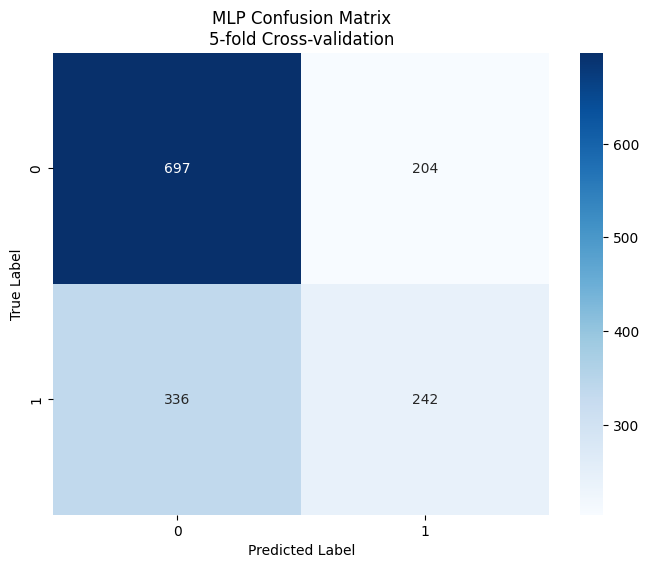

In [18]:
plot_cross_val_confusion_matrix(confusion_matrix, display_labels='', title='MLP Confusion Matrix', cv=5)
plt.show()

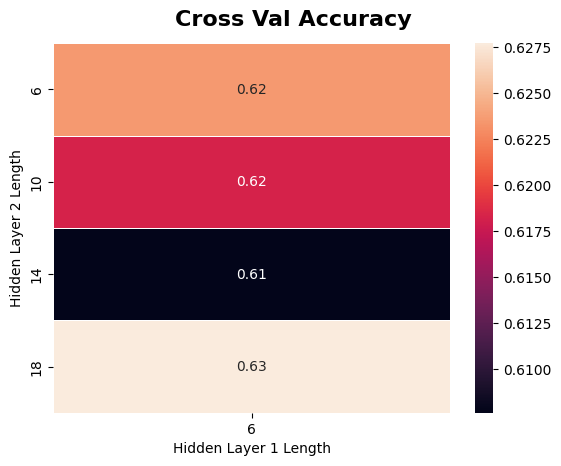

In [19]:
# Tạo ma trận dữ liệu Z
matrix_plot_data = pd.DataFrame({})
matrix_plot_data['x'] = list(zip(*hidden_layer_test))[0]
matrix_plot_data['y'] = list(zip(*hidden_layer_test))[1]
matrix_plot_data['z'] = grid_search.cv_results_['mean_test_score']
Z = matrix_plot_data.pivot_table(index='x', columns='y', values='z').T.values

# Lấy các giá trị duy nhất trên trục x và trục y
X_unique = np.sort(matrix_plot_data.x.unique())
Y_unique = np.sort(matrix_plot_data.y.unique())

# Vẽ đồ thị heatmap
fig, ax = plt.subplots()
heatmap = sns.heatmap(Z, annot=True, linewidths=.5, ax=ax)

# Thiết lập nhãn trục x và trục y
ax.set_xticklabels(X_unique)
ax.set_yticklabels(Y_unique)

# Thiết lập tên trục
ax.set(xlabel='Hidden Layer 1 Length', ylabel='Hidden Layer 2 Length')
fig.suptitle('Cross Val Accuracy', y=0.95, fontsize=16, fontweight='bold')

# Hiển thị đồ thị
plt.show()